In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary, set_trainable
import gpflux
import gpflow
import tensorflow as tf

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

from sklearn.metrics import mean_squared_error, mean_absolute_error
from properscoring import crps_gaussian

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data
from useful_fun import plot_distribution_gpflux, percentage_outof_CI, number_outof_CI

tf.keras.backend.set_floatx("float64")

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data, train_test=False)
x = x.numpy().reshape(-1,1)
y = y.numpy().reshape(-1,1)

# train/test split
df_train = pd.read_csv('../../data/train.csv')
x_train, y_train = separate_data(df_train)
df_test = pd.read_csv('../../data/test.csv')
x_test, y_test = separate_data(df_test)

x_train = x_train.numpy().reshape(-1,1)
y_train = y_train.numpy().reshape(-1,1)
x_test = x_test.numpy().reshape(-1,1)
y_test = y_test.numpy().reshape(-1,1)

# get date for x-axis in plots
def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs
pos, labels = get_xticks(data)

2022-08-30 15:49:42.902554: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 15:49:43.509029: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5


# Deep GP model

Let's first try running a two layer model to test the model.

inducing points = 1000 and RBF kernels for both layers.

In [3]:
def build_train_1layer_dgp(kernel1, num_inducing=1000, batch_size=500):
    Z = np.linspace(x_train.min(), x_train.max(), num_inducing).reshape(-1, 1)

    # layer 1 set up
    inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer1 = gpflux.layers.GPLayer(
        kernel1, 
        inducing_variable1, 
        num_data=len(x_train), 
        num_latent_gps=y.shape[1],
        mean_function=gpflow.mean_functions.Zero()
    )

    # model construction
    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
    one_layer_dgp = gpflux.models.DeepGP([gp_layer1], likelihood_layer)

    model = one_layer_dgp.as_training_model()
    model.compile(tf.optimizers.Adam(0.1))

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=2, min_lr=1e-6, verbose=0),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    ]


    history = model.fit({"inputs": x_train, "targets": y_train}, batch_size=batch_size, epochs=500, verbose=0, callbacks=callbacks)
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].plot(history.history["loss"])
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Objective = neg. ELBO")
    ax[0].set_title('ELBO during training')
    ax[1].plot(history.history["lr"])
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Learning rate")
    ax[1].set_title('Learning rate during training')
    plt.show()
    

    model = one_layer_dgp.as_prediction_model()

    print('Training Set')
    fitted_values = model(x_train)
    mean_train = fitted_values.y_mean.numpy().squeeze()
    noise = model.layers[-1].likelihood.variance.numpy()
    var_train = fitted_values.f_var.numpy().squeeze() + noise
    plot_distribution_gpflux(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    print('Testing Set')
    pred = model(x_test)
    mean_test = pred.y_mean.numpy().squeeze()
    var_test = pred.f_var.numpy().squeeze() + noise
    plot_distribution_gpflux(x_test, y_test, mean_test, var_test, pos, labels)

    print('Train ELBO, MSE, MAE: ', one_layer_dgp.elbo((x_train, y_train)).numpy(), 
                                    mean_squared_error(y_train, mean_train), 
                                    np.mean(crps_gaussian(y_train, mean_train, np.sqrt(var_train))),
                                    percentage_outof_CI(y_train, mean_train, var_train))

    print('Test ELBO, MSE, MAE: ', one_layer_dgp.elbo((x_test, y_test)).numpy(), 
                                    mean_squared_error(y_test, mean_test), 
                                    np.mean(crps_gaussian(y_test, mean_test, np.sqrt(var_test))),
                                    percentage_outof_CI(y_test, mean_test, var_test))

    print_summary(one_layer_dgp, fmt="notebook")

In [4]:
def build_train_2layer_dgp(kernel1, kernel2, num_inducing=1000, batch_size=500):
    Z = np.linspace(x_train.min(), x_train.max(), num_inducing).reshape(-1, 1)

    # layer 1 set up
    inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer1 = gpflux.layers.GPLayer(
        kernel1, 
        inducing_variable1, 
        num_data=len(x_train), 
        num_latent_gps=y.shape[1]
    )

    # layer 2 set up
    inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer2 = gpflux.layers.GPLayer(
        kernel2,
        inducing_variable2,
        num_data=len(x_train),
        num_latent_gps=y.shape[1],
        mean_function=gpflow.mean_functions.Zero()
    )

    # model construction
    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
    two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)

    model = two_layer_dgp.as_training_model()
    model.compile(tf.optimizers.Adam(0.01))

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=2, min_lr=1e-6, verbose=0),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    ]
    history = model.fit({"inputs": x_train, "targets": y_train}, batch_size=batch_size, epochs=500, verbose=0, callbacks=callbacks)
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].plot(history.history["loss"])
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Objective = neg. ELBO")
    ax[0].set_title('ELBO during training')
    ax[1].plot(history.history["lr"])
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Learning rate")
    ax[1].set_title('Learning rate during training')
    plt.show()

    model = two_layer_dgp.as_prediction_model()

    print('Training Set')
    fitted_values = model(x_train)
    mean_train = fitted_values.y_mean.numpy().squeeze()
    noise = model.layers[-1].likelihood.variance.numpy()
    var_train = fitted_values.f_var.numpy().squeeze() + noise
    plot_distribution_gpflux(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    print('Testing Set')
    pred = model(x_test)
    mean_test = pred.y_mean.numpy().squeeze()
    var_test = pred.f_var.numpy().squeeze() + noise
    plot_distribution_gpflux(x_test, y_test, mean_test, var_test, pos, labels)

    print('Train ELBO, MSE, MAE: ', two_layer_dgp.elbo((x_train, y_train)).numpy(), 
                                    mean_squared_error(y_train, mean_train), 
                                    np.mean(crps_gaussian(y_train, mean_train, np.sqrt(var_train))),
                                    percentage_outof_CI(y_train, mean_train, var_train))

    print('Test ELBO, MSE, MAE: ', two_layer_dgp.elbo((x_test, y_test)).numpy(), 
                                    mean_squared_error(y_test, mean_test), 
                                    np.mean(crps_gaussian(y_test, mean_test, np.sqrt(var_test))),
                                    percentage_outof_CI(y_test, mean_test, var_test))

    print_summary(two_layer_dgp, fmt="notebook")

In [5]:
def build_train_3layer_dgp(kernel1, kernel2, kernel3, num_inducing=1000, batch_size=500):
    Z = np.linspace(x_train.min(), x_train.max(), num_inducing).reshape(-1, 1)

    # layer 1 set up
    inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer1 = gpflux.layers.GPLayer(
        kernel1, 
        inducing_variable1, 
        num_data=len(x_train), 
        num_latent_gps=y.shape[1]
    )

    # layer 2 set up
    inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer2 = gpflux.layers.GPLayer(
        kernel2,
        inducing_variable2,
        num_data=len(x_train),
        num_latent_gps=y.shape[1]
    )

    # layer 3 set up
    inducing_variable3 = gpflow.inducing_variables.InducingPoints(Z.copy())
    gp_layer3 = gpflux.layers.GPLayer(
        kernel3,
        inducing_variable3,
        num_data=len(x_train),
        num_latent_gps=y.shape[1],
        mean_function=gpflow.mean_functions.Zero()
    )

    # model construction
    likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
    three_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2, gp_layer3], likelihood_layer)

    model = three_layer_dgp.as_training_model()
    model.compile(tf.optimizers.Adam(0.1))

    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=2, min_lr=1e-6, verbose=0),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    ]


    history = model.fit({"inputs": x_train, "targets": y_train}, batch_size=batch_size, epochs=500, verbose=0, callbacks=callbacks)
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].plot(history.history["loss"])
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Objective = neg. ELBO")
    ax[0].set_title('ELBO during training')
    ax[1].plot(history.history["lr"])
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Learning rate")
    ax[1].set_title('Learning rate during training')
    plt.show()
    

    model = three_layer_dgp.as_prediction_model()

    print('Training Set')
    fitted_values = model(x_train)
    mean_train = fitted_values.y_mean.numpy().squeeze()
    noise = model.layers[-1].likelihood.variance.numpy()
    var_train = fitted_values.f_var.numpy().squeeze() + noise
    plot_distribution_gpflux(x_train, y_train, mean_train, var_train, pos, labels, legend=False)

    print('Testing Set')
    pred = model(x_test)
    mean_test = pred.y_mean.numpy().squeeze()
    var_test = pred.f_var.numpy().squeeze() + noise
    plot_distribution_gpflux(x_test, y_test, mean_test, var_test, pos, labels)

    print('Train ELBO, MSE, MAE: ', three_layer_dgp.elbo((x_train, y_train)).numpy(), 
                                    mean_squared_error(y_train, mean_train), 
                                    np.mean(crps_gaussian(y_train, mean_train, np.sqrt(var_train))),
                                    percentage_outof_CI(y_train, mean_train, var_train))

    print('Test ELBO, MSE, MAE: ', three_layer_dgp.elbo((x_test, y_test)).numpy(), 
                                    mean_squared_error(y_test, mean_test), 
                                    np.mean(crps_gaussian(y_test, mean_test, np.sqrt(var_test))),
                                    percentage_outof_CI(y_test, mean_test, var_test))

    print_summary(three_layer_dgp, fmt="notebook")

# Test architectures 

2layer model


2022-08-30 15:50:00.712566: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-30 15:50:06.344828: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x76bf960


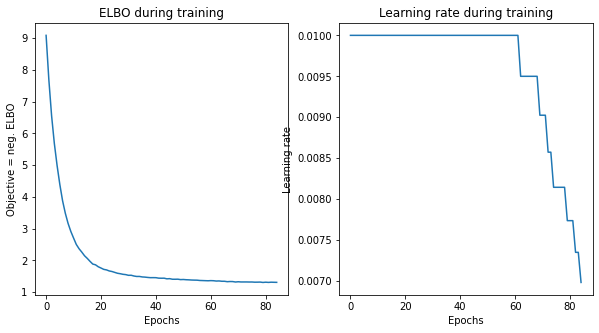

Training Set


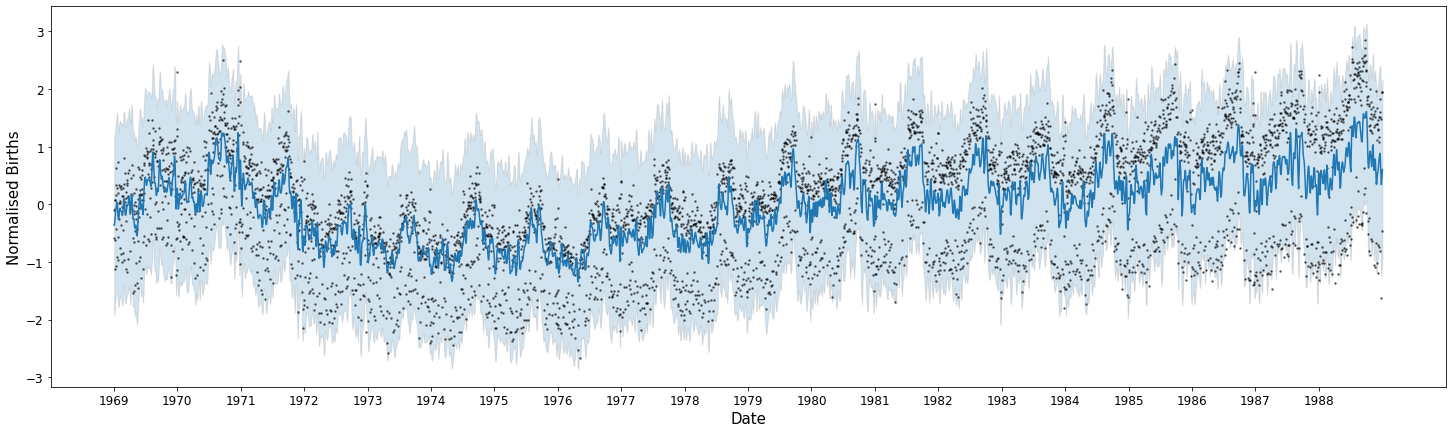

Testing Set


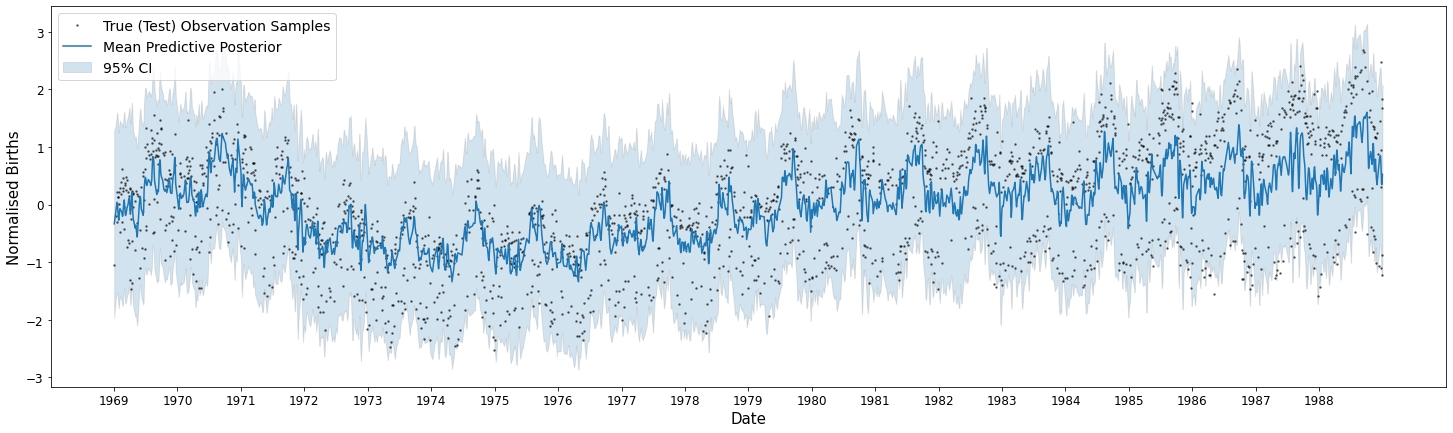

Train ELBO, MSE, MAE:  -6674.219568831119 0.5025339817466881 0.6904716925871374 20.224965457943647
Test ELBO, MSE, MAE:  -7859.139810203362 0.7222150467596897 0.6997473040558992 20.170726996643403


In [6]:
print('2layer model')
build_train_2layer_dgp(gpflow.kernels.RBF(), gpflow.kernels.RBF(), num_inducing=1500, batch_size=500)

1layer model


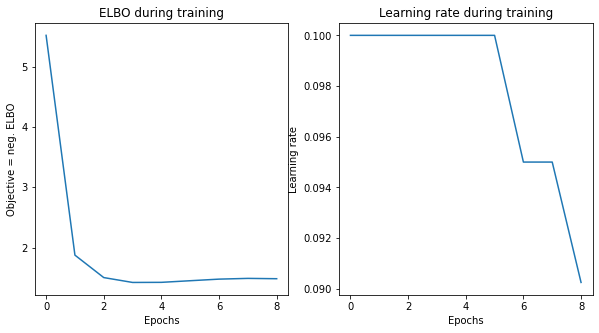

Training Set


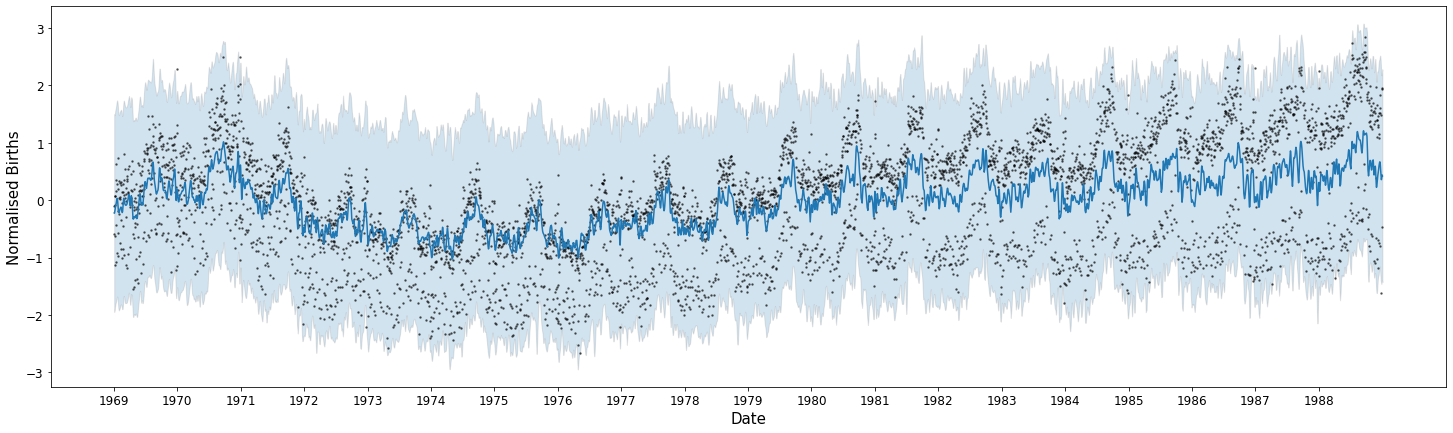

Testing Set


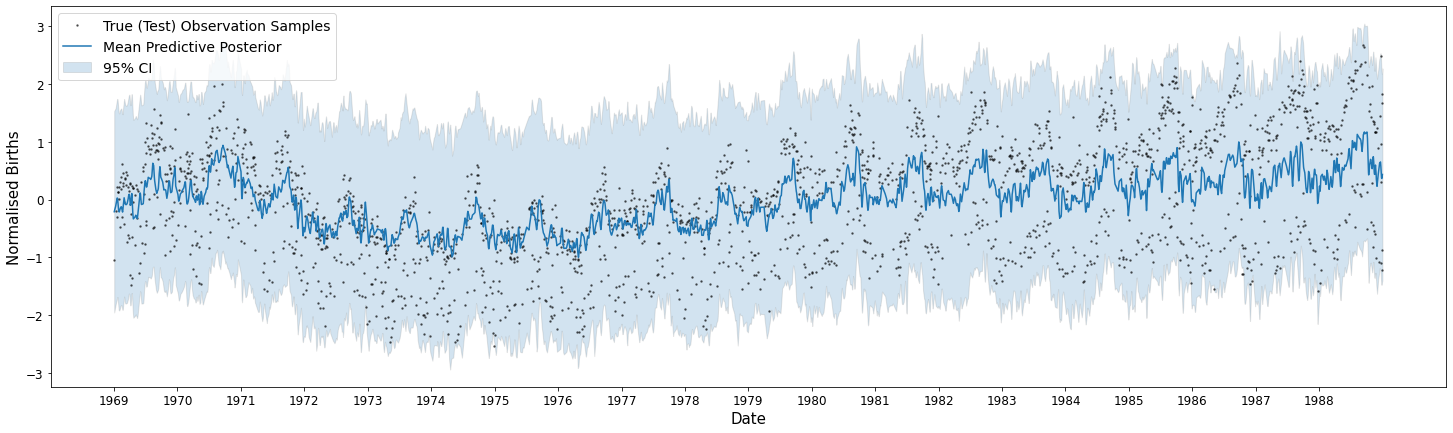

Train ELBO, MSE, MAE:  -7559.878586956122 0.561692998216488 0.6342026852987495 9.351736994654239
Test ELBO, MSE, MAE:  -8170.156419961152 0.719765103955819 0.6407873491862383 9.433544841227556


In [7]:
print('1layer model')
build_train_1layer_dgp(gpflow.kernels.RBF(), num_inducing=1500, batch_size=500)

3layer model


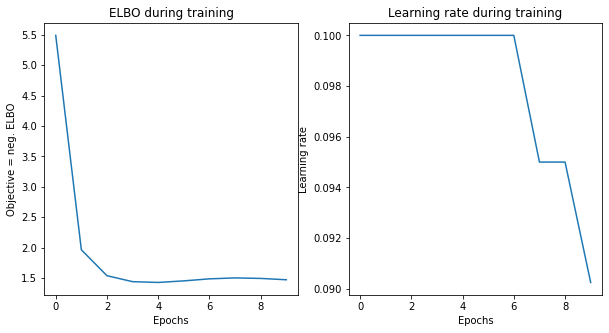

Training Set


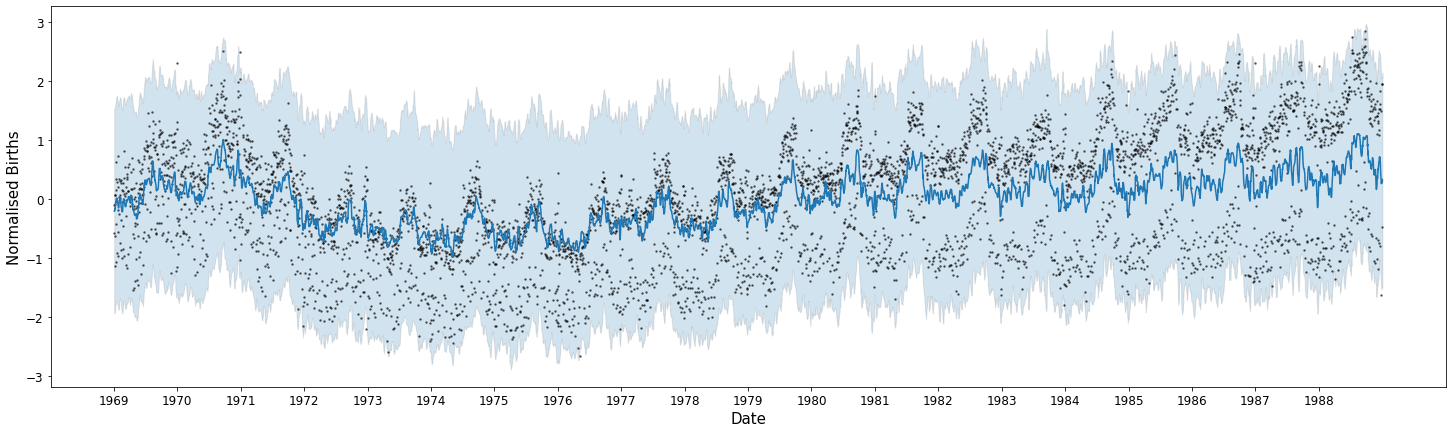

Testing Set


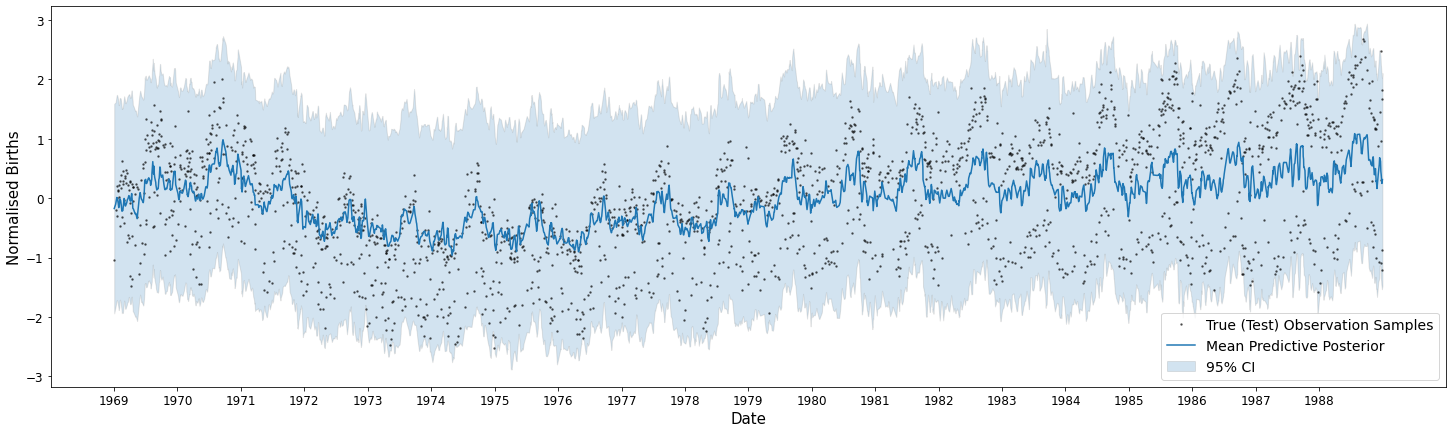

Train ELBO, MSE, MAE:  -7480.98169715713 0.5766970864915247 0.62889400543737 8.973946103413912
Test ELBO, MSE, MAE:  -8004.437799714168 0.7130840814096367 0.6366575688094102 9.144650087910918


In [8]:
print('3layer model')
build_train_3layer_dgp(gpflow.kernels.RBF(), gpflow.kernels.RBF(), gpflow.kernels.RBF(), num_inducing=1500, batch_size=500)

# Kernel selection

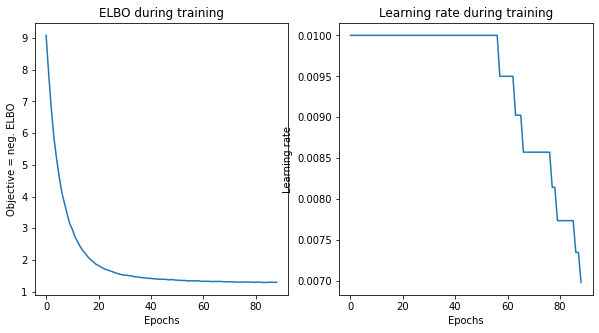

Training Set


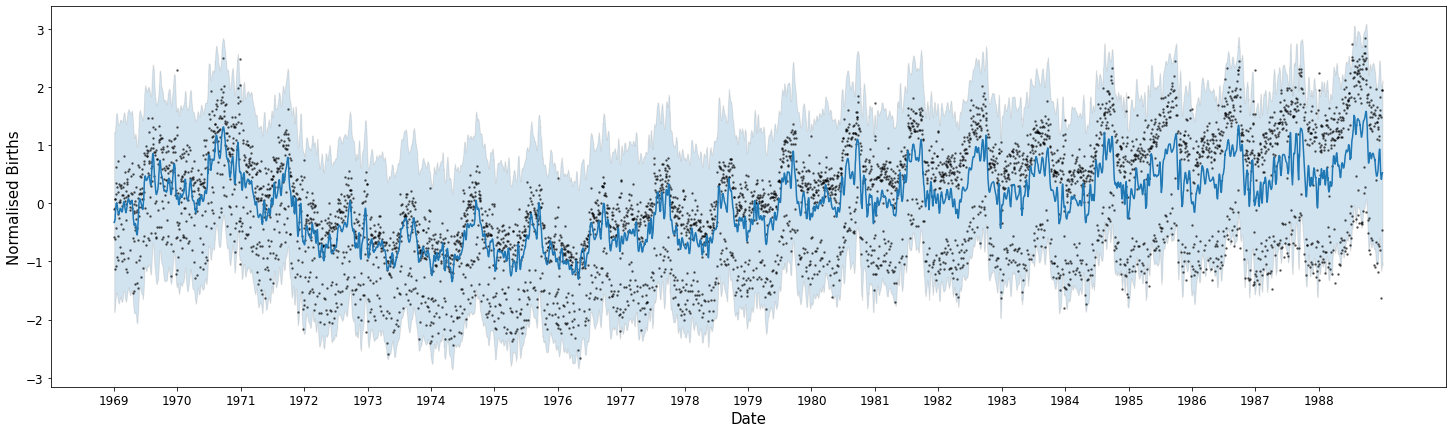

Testing Set


Train ELBO, MSE, MAE:  -6586.656340505723 0.5166456222581204 0.690040211159992 20.01655218695464
Test ELBO, MSE, MAE:  -7481.733590935038 0.6870624550118686 0.6999582046789734 20.183526526453193


------------------------


Training Set


Testing Set


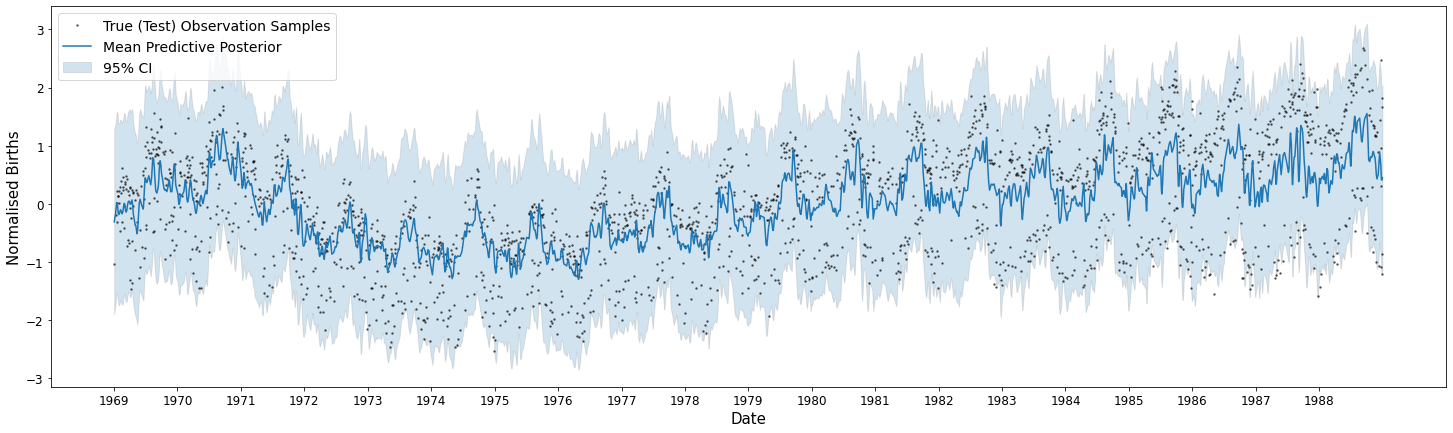

Train ELBO, MSE, MAE:  -6542.389485544464 0.516827855173933 0.6883927018613819 19.247073636308382
Test ELBO, MSE, MAE:  -7379.518003573417 0.6839195652881024 0.6985718472721149 19.472580285310883


------------------------


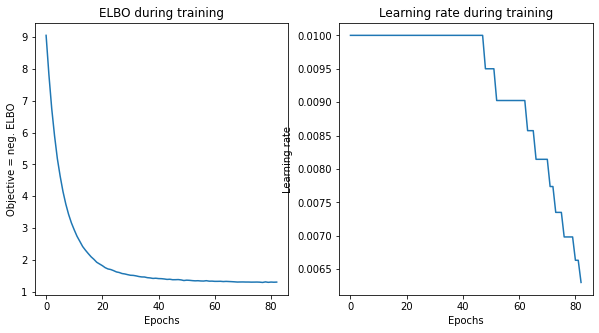

Training Set


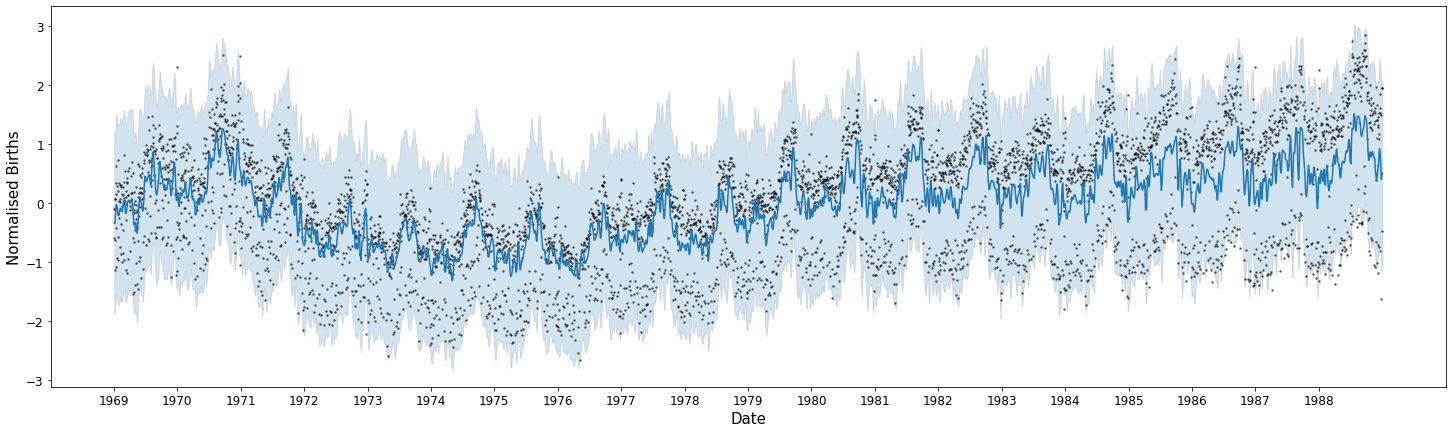

Testing Set


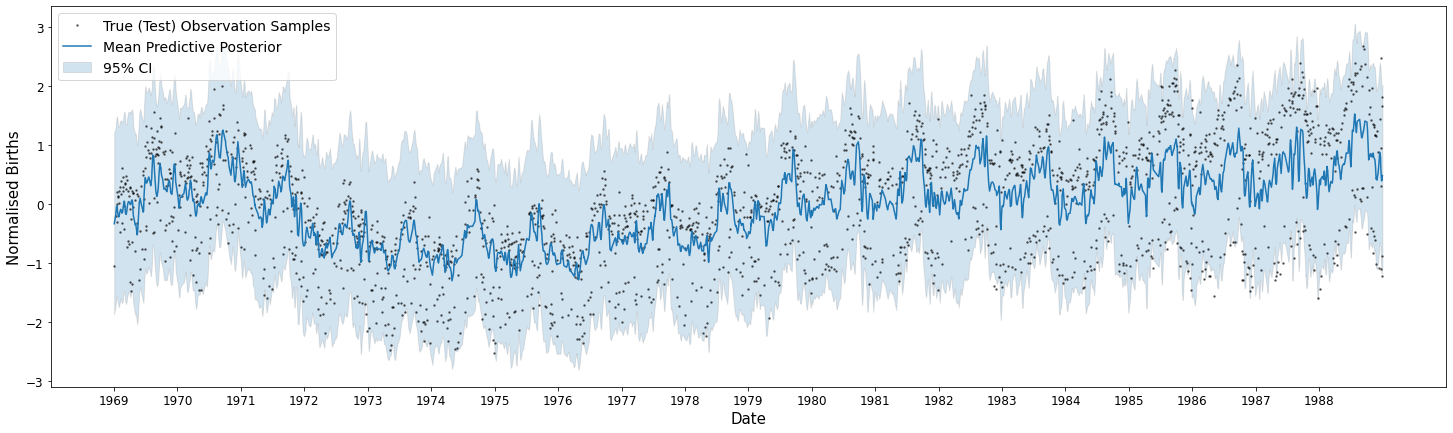

Train ELBO, MSE, MAE:  -6624.206351328716 0.5163583053147406 0.6912656625913367 20.528089430771466
Test ELBO, MSE, MAE:  -7549.356065562772 0.6890948975331603 0.7005733320488687 20.623643041717727


------------------------


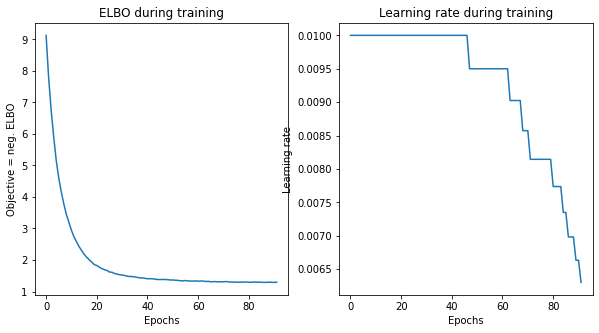

Training Set


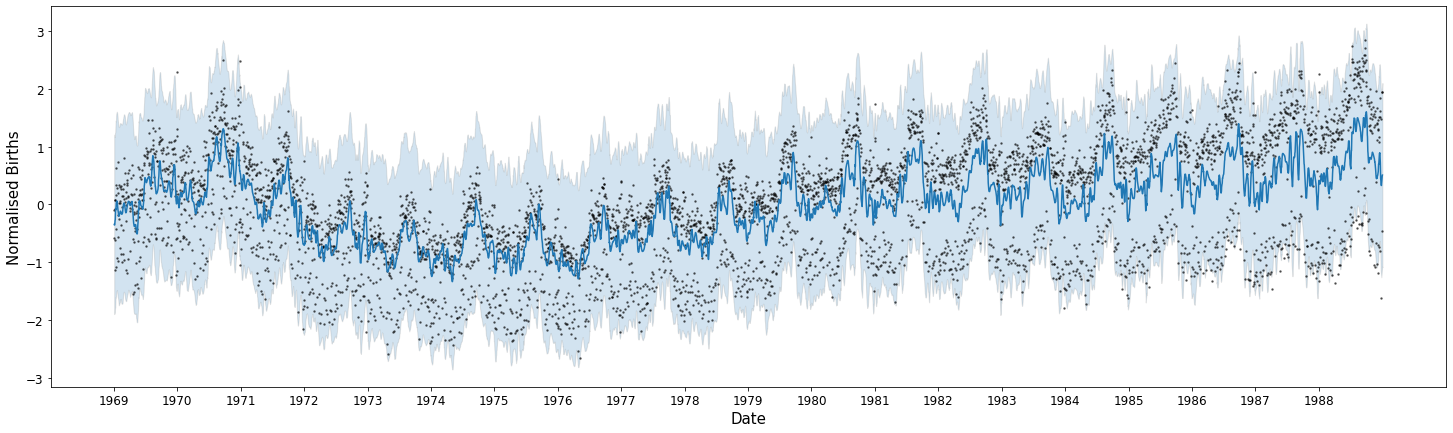

Testing Set


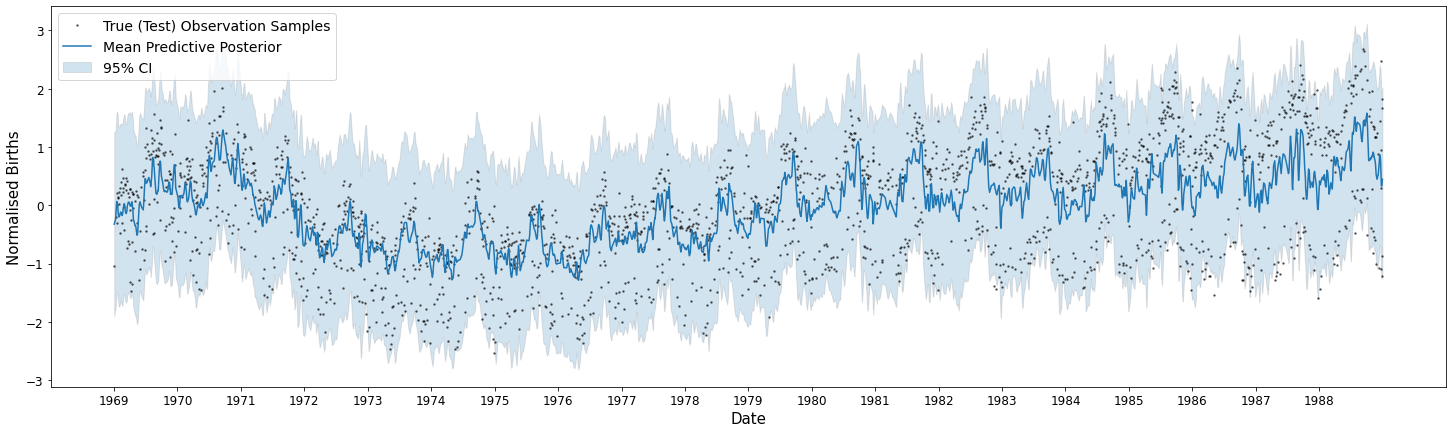

Train ELBO, MSE, MAE:  -6583.296647977618 0.515939758678338 0.6904211070912403 19.971981544877668
Test ELBO, MSE, MAE:  -7476.328018386968 0.6878159351915886 0.7000138821036861 20.122109595609782


------------------------


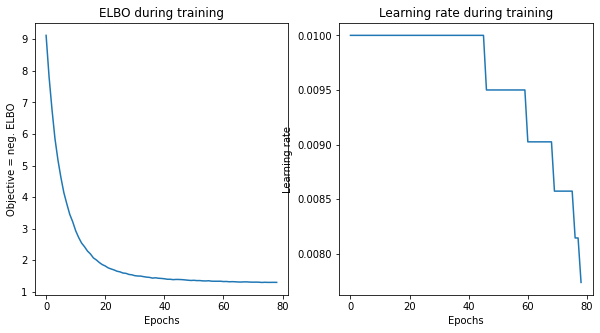

Training Set


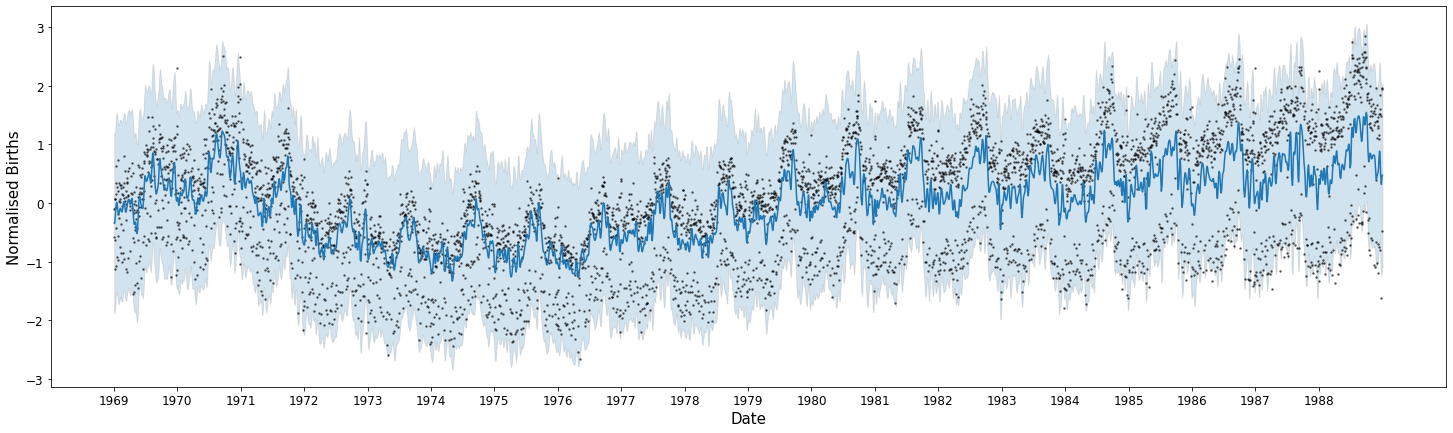

Testing Set


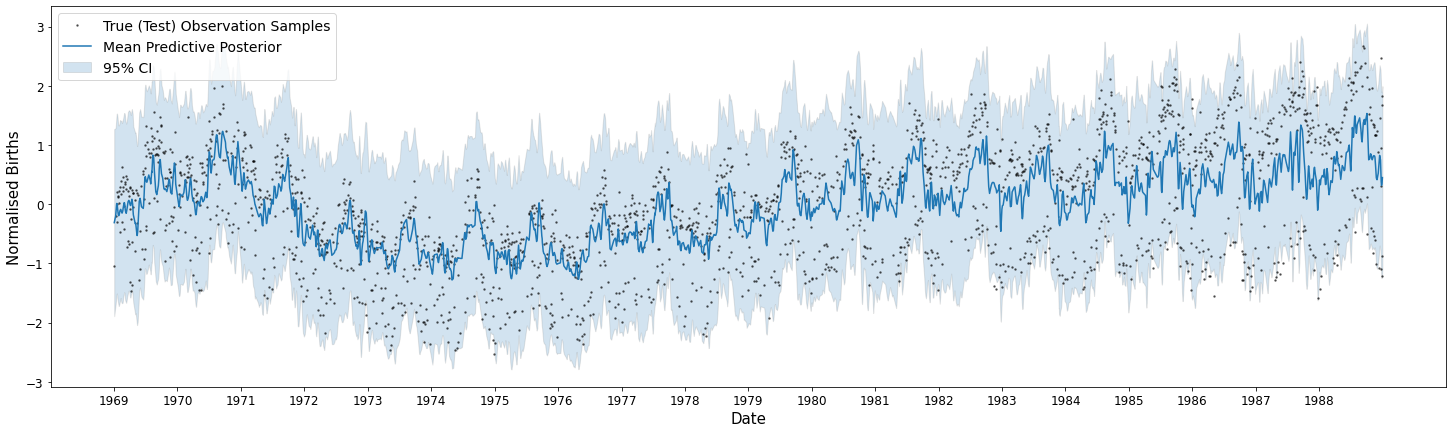

Train ELBO, MSE, MAE:  -6628.144839140975 0.5157827618984689 0.6910451790431807 20.592734457470822
Test ELBO, MSE, MAE:  -7575.045154151411 0.690287883204036 0.7004126665964283 20.66886804704566


------------------------


In [8]:
kernel_list1 = [gpflow.kernels.RBF(), gpflow.kernels.Matern12(), gpflow.kernels.Matern32(), gpflow.kernels.Matern52(), gpflow.kernels.Periodic(gpflow.kernels.Matern32())]

for k1 in kernel_list1:
    print(k1)
    build_train_2layer_dgp(k1, gpflow.kernels.RBF(), num_inducing=1000, batch_size=500)
    print('------------------------')

starting value of l1, l2:  1 30


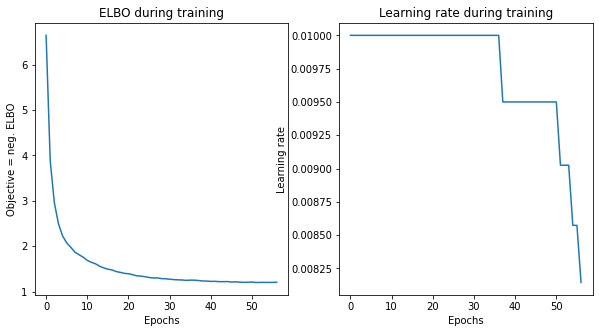

Training Set


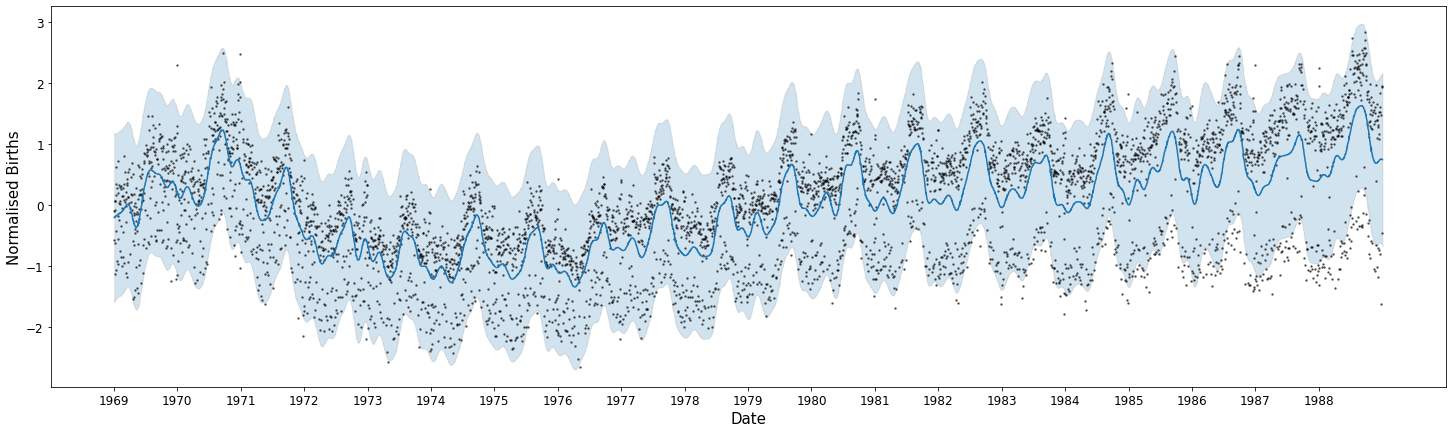

Testing Set


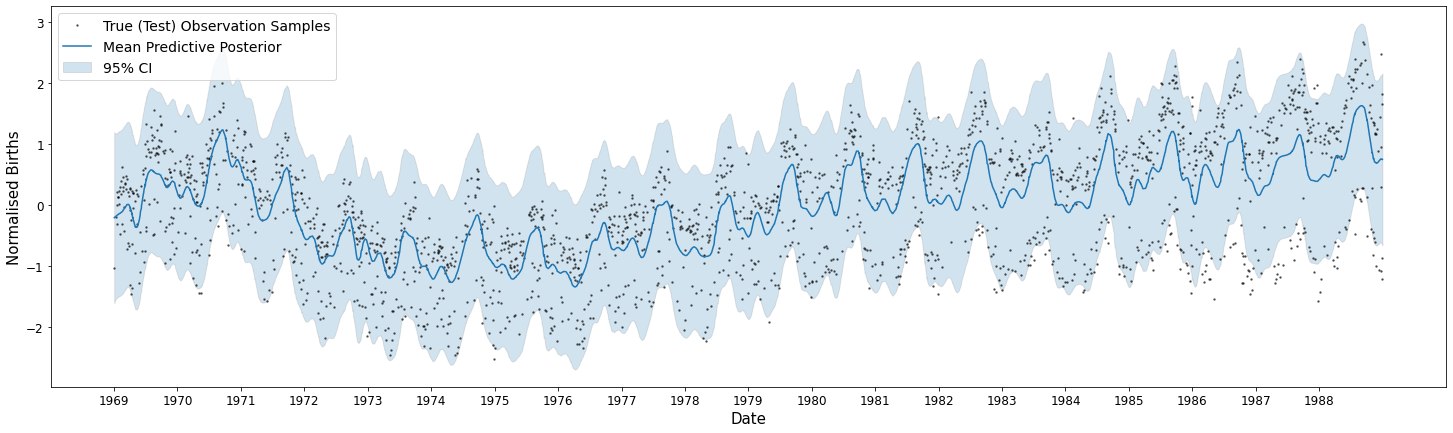

Train ELBO, MSE, MAE:  -6119.377188611254 0.5424040665467683 0.7260868616088835 27.596491404563917
Test ELBO, MSE, MAE:  -6412.476215201211 0.5947695157195355 0.7417691755260238 28.62942634796739


------------------------
starting value of l1, l2:  170 365


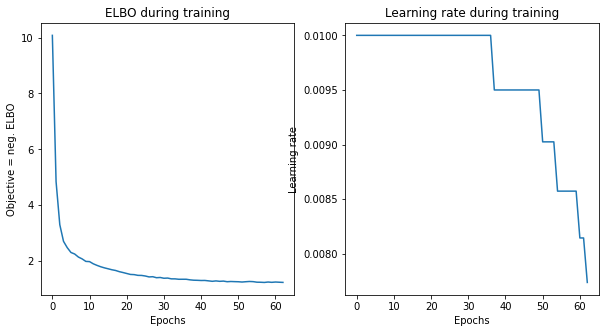

Training Set


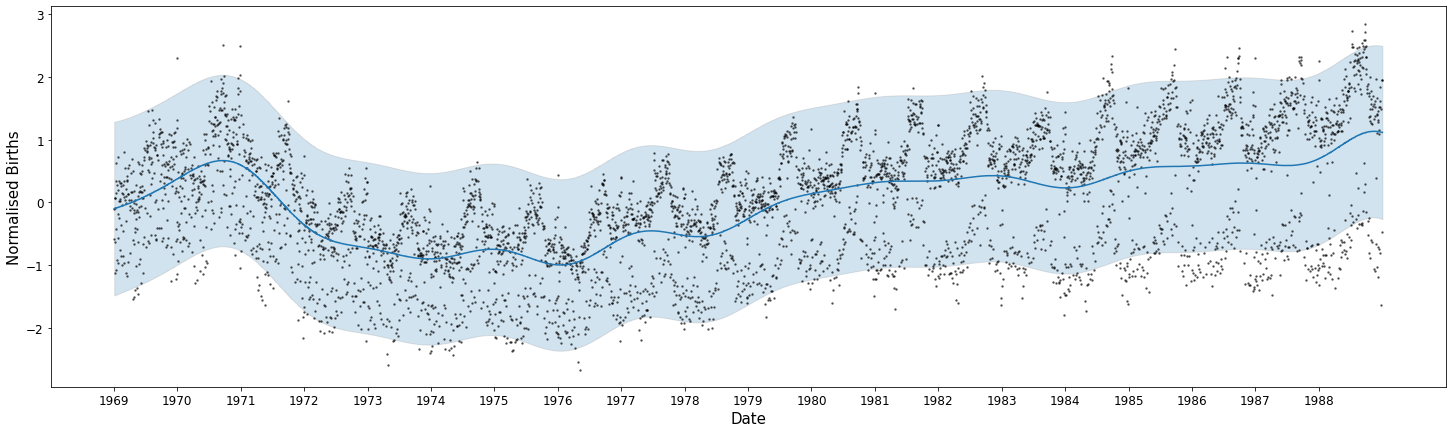

Testing Set


Train ELBO, MSE, MAE:  -6343.172601649477 0.649838954260061 0.696617479056954 25.37855113970521
Test ELBO, MSE, MAE:  -6475.423588934344 0.6746971538405072 0.7094254929083543 26.34128666284831


------------------------
starting value of l1, l2:  365 77


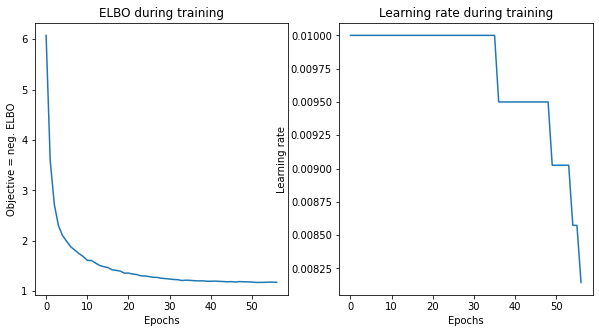

Training Set


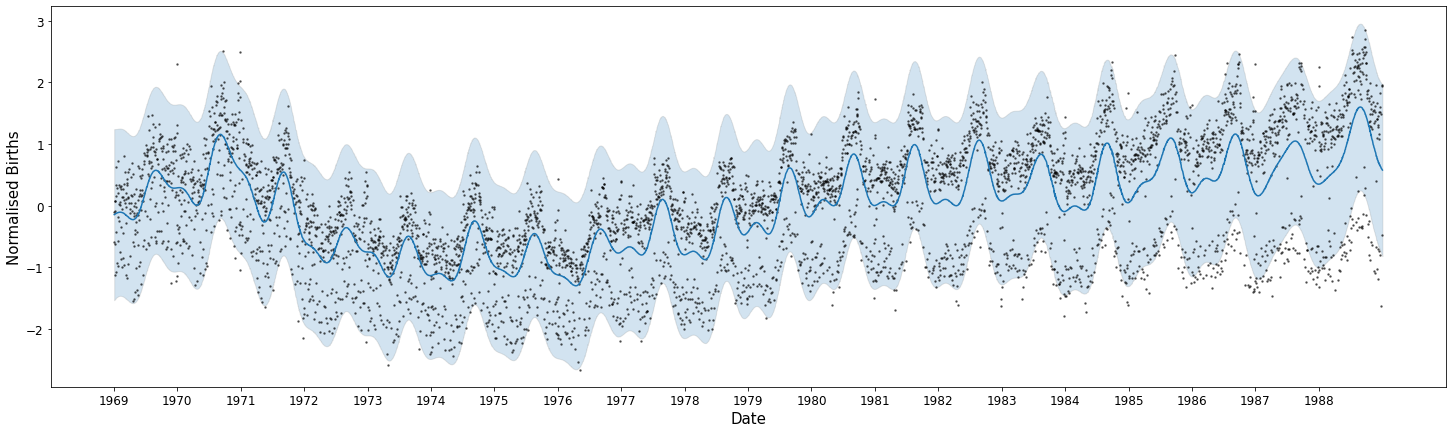

Testing Set


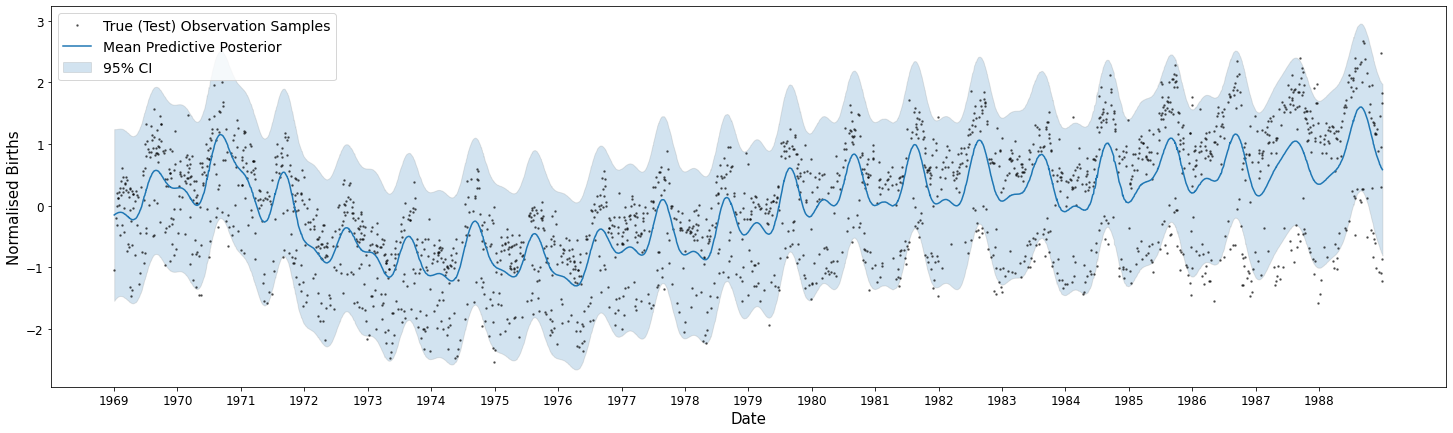

Train ELBO, MSE, MAE:  -5989.742354215018 0.5527689807087753 0.7250955587241541 27.423544919820852
Test ELBO, MSE, MAE:  -6177.798970417086 0.5866100076795963 0.7412831322981116 28.52915295833555


------------------------
starting value of l1, l2:  77 30


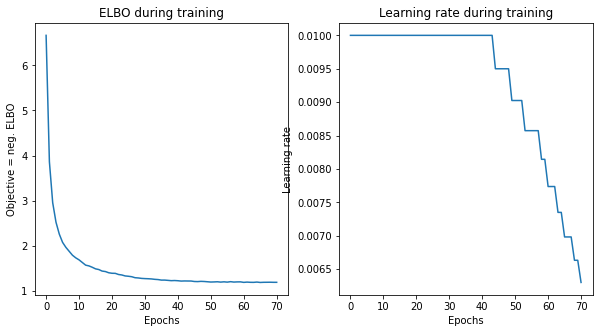

Training Set


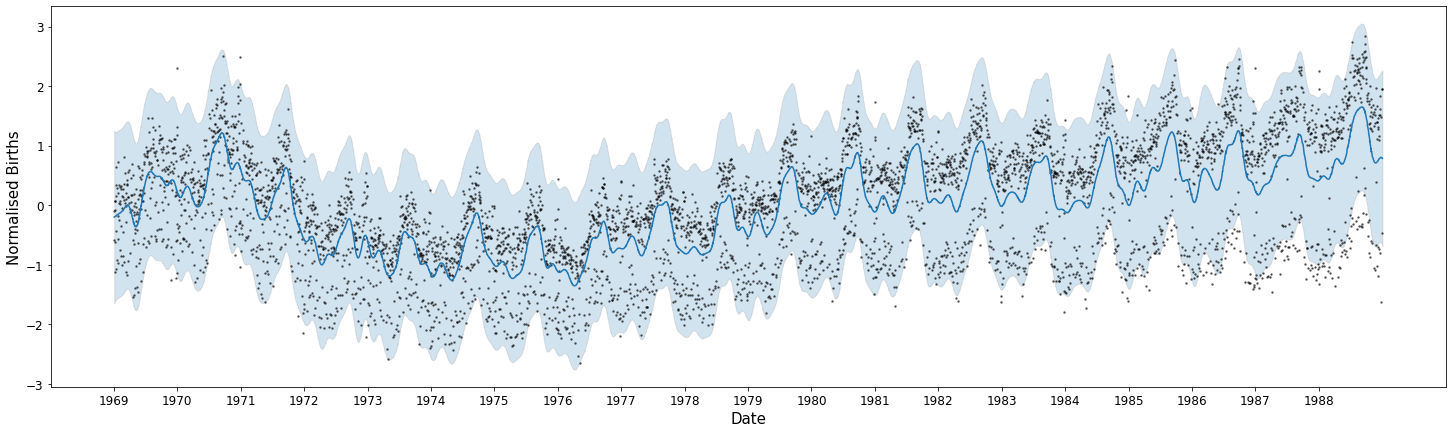

Testing Set


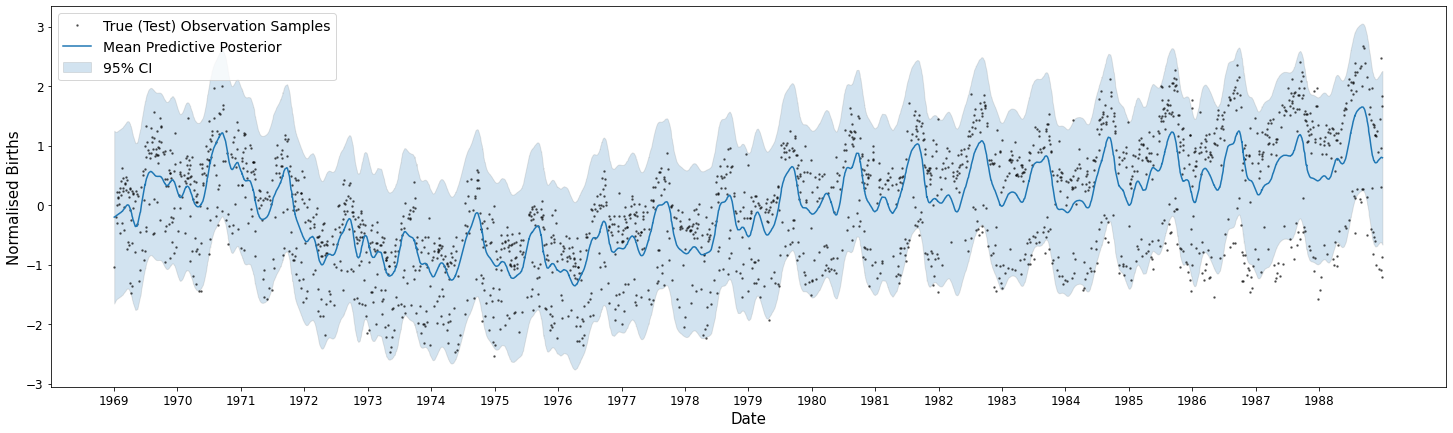

Train ELBO, MSE, MAE:  -6079.689670830546 0.5425334234007679 0.7209830880243782 25.63491265978749
Test ELBO, MSE, MAE:  -6357.600007137144 0.5951054334104295 0.7366954373585393 26.67713383771112


------------------------


In [9]:
ls = [[1, 30], [170, 365], [365, 77], [77, 30]]
for l in ls:
    print('starting value of l1, l2: ', l[0], l[1])
    build_train_2layer_dgp(gpflow.kernels.RBF(lengthscales=l[0]), gpflow.kernels.RBF(lengthscales=l[1]), num_inducing=1500, batch_size=500)
    print('------------------------')

# 3 layer

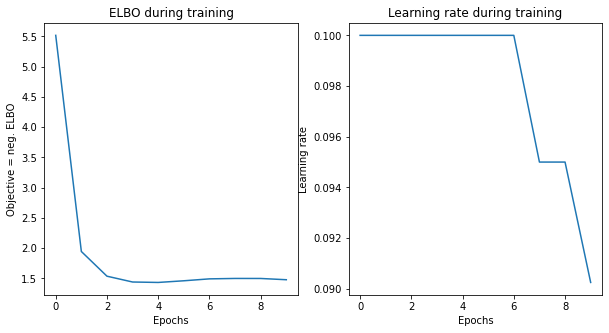

Training Set


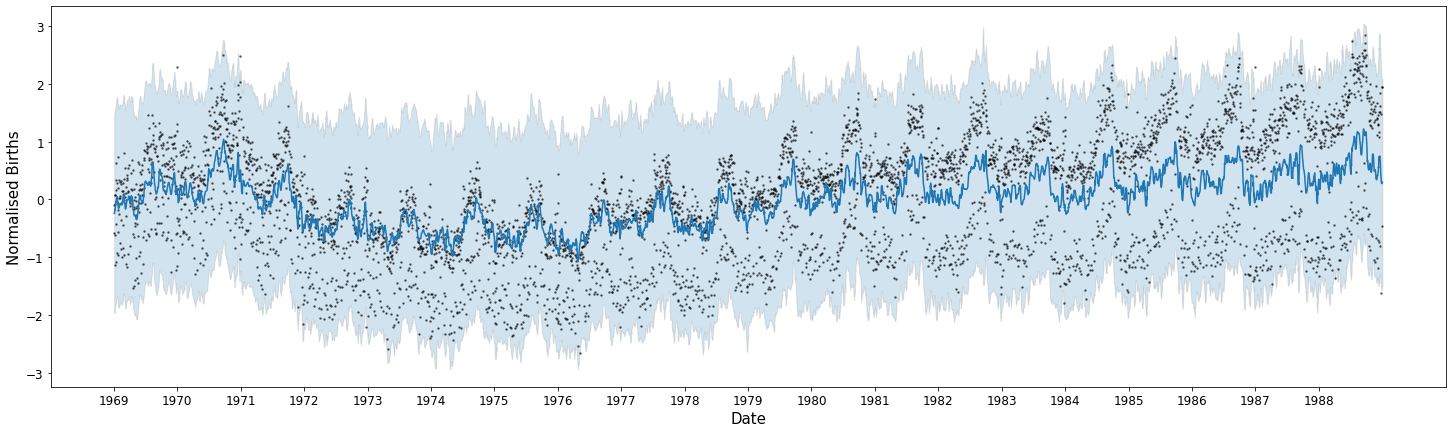

Testing Set


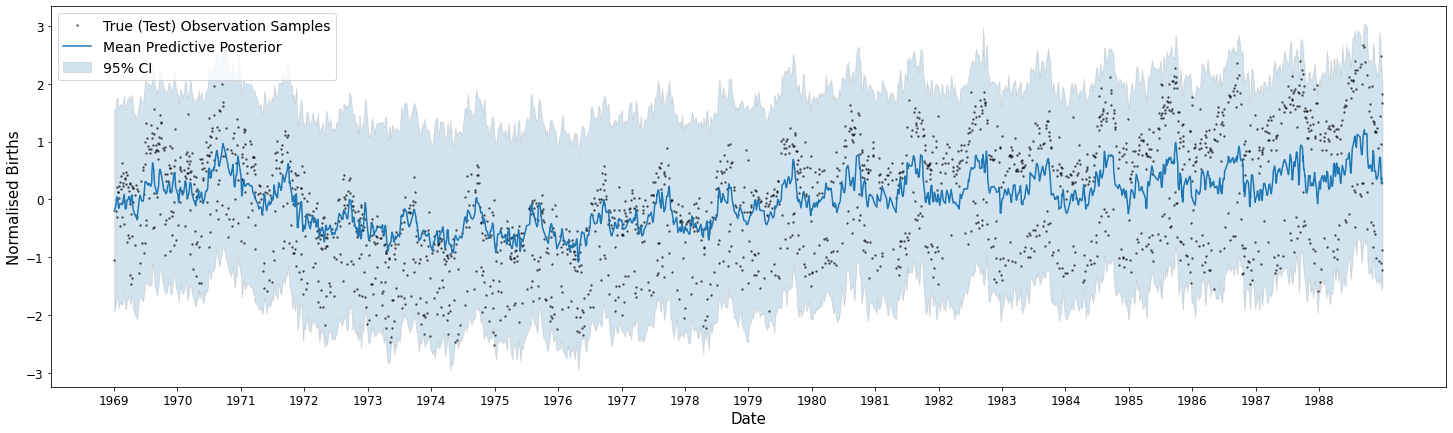

Train ELBO, MSE, MAE:  -7482.526239351528 0.5735244086375719 0.630099732458594 9.040025561179078
Test ELBO, MSE, MAE:  -8006.133968364827 0.7142622079469351 0.6375715585674304 9.194224852149821


In [24]:
kernel1 = gpflow.kernels.RBF()
kernel2 = gpflow.kernels.Matern32()
kernel3 = gpflow.kernels.RBF()

build_train_3layer_dgp(kernel1, kernel2, kernel3, num_inducing=1500, batch_size=500)

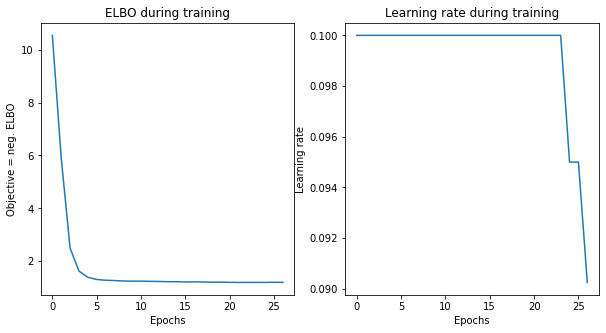

Training Set


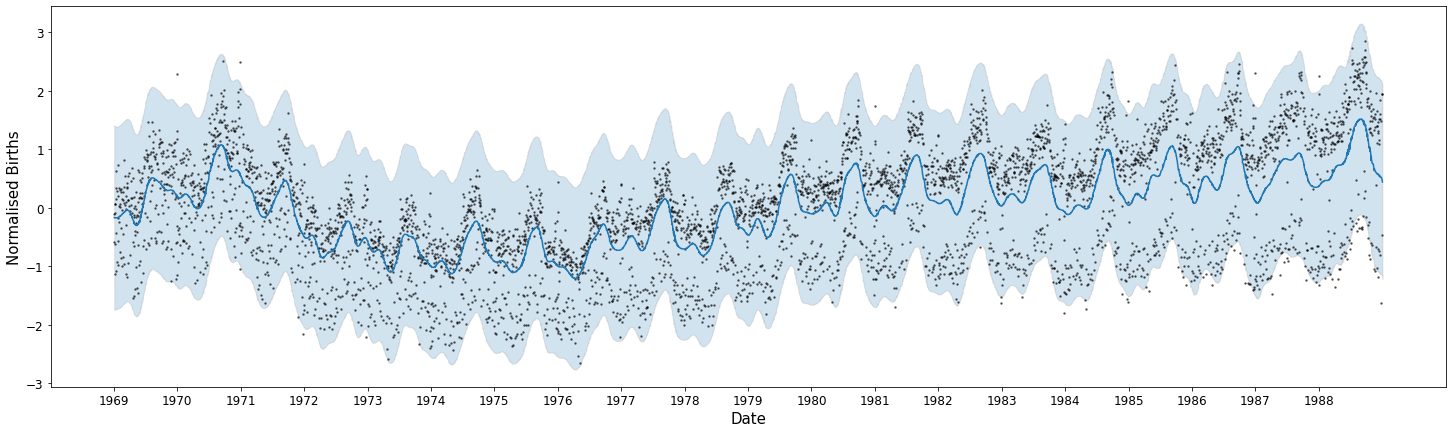

Testing Set


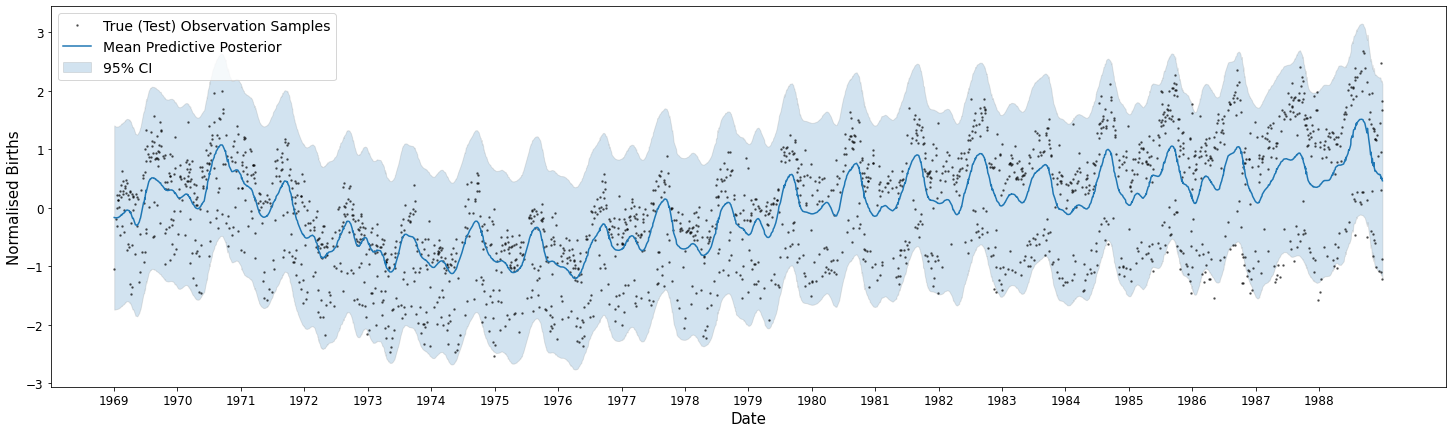

Train ELBO, MSE, MAE:  -6162.1570558836775 0.5522859932638414 0.6856636288497333 18.687886505059964
Test ELBO, MSE, MAE:  -6343.7862257095385 0.5948184813163423 0.6995672472991363 19.45936451062923


In [25]:
kernel1 = gpflow.kernels.RBF(lengthscales=30)
kernel2 = gpflow.kernels.Matern32(lengthscales=365)
kernel3 = gpflow.kernels.RBF(lengthscales=30)

build_train_3layer_dgp(kernel1, kernel2, kernel3, num_inducing=1500, batch_size=500)

# 1 layer DGP

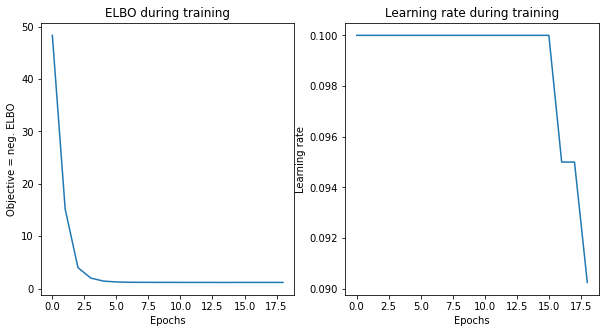

Training Set


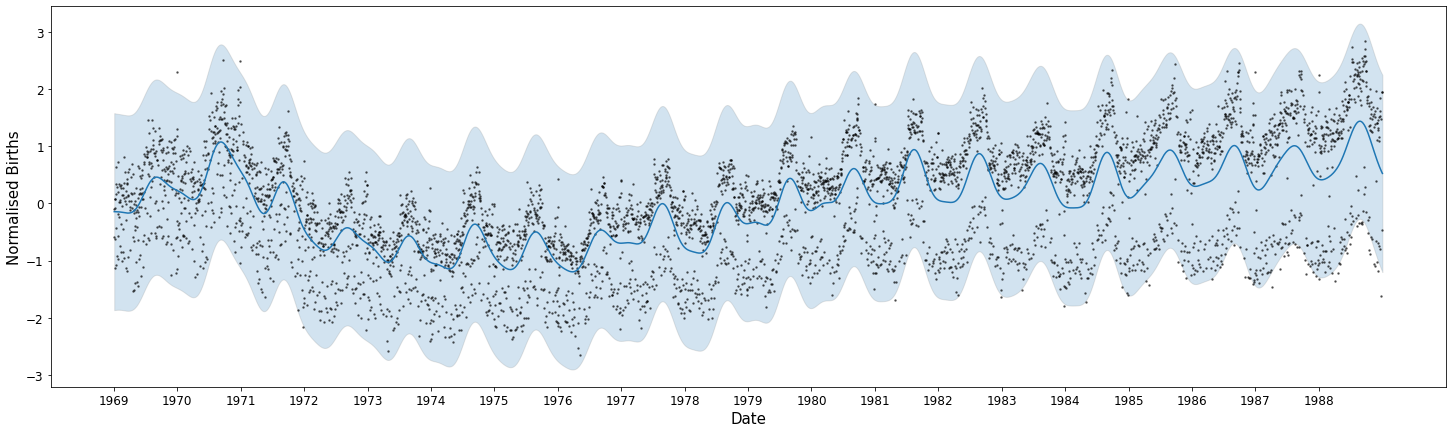

Testing Set


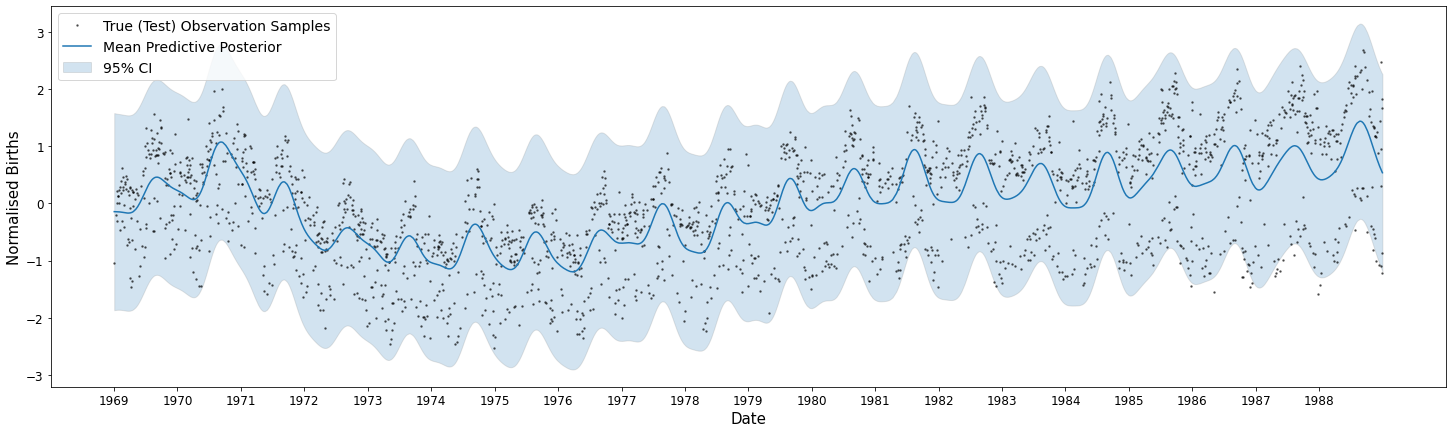

Train ELBO, MSE, MAE:  -6061.4117816557655 0.5618166689445924 0.6868698841413609 15.203557817459965
Test ELBO, MSE, MAE:  -6182.692656103581 0.5971710129317254 0.7011254040815696 15.915289173637381


In [30]:
kernel1 = gpflow.kernels.RBF(lengthscales=77)

build_train_1layer_dgp(kernel1, num_inducing=1500, batch_size=500)

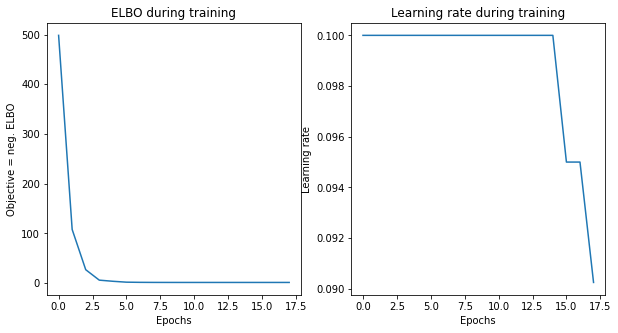

Training Set


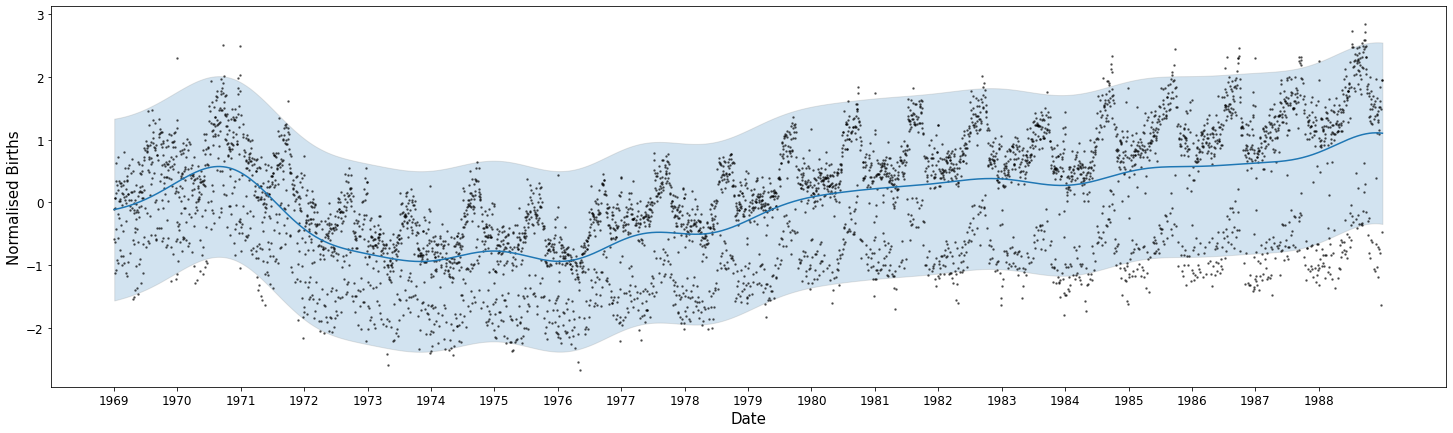

Testing Set


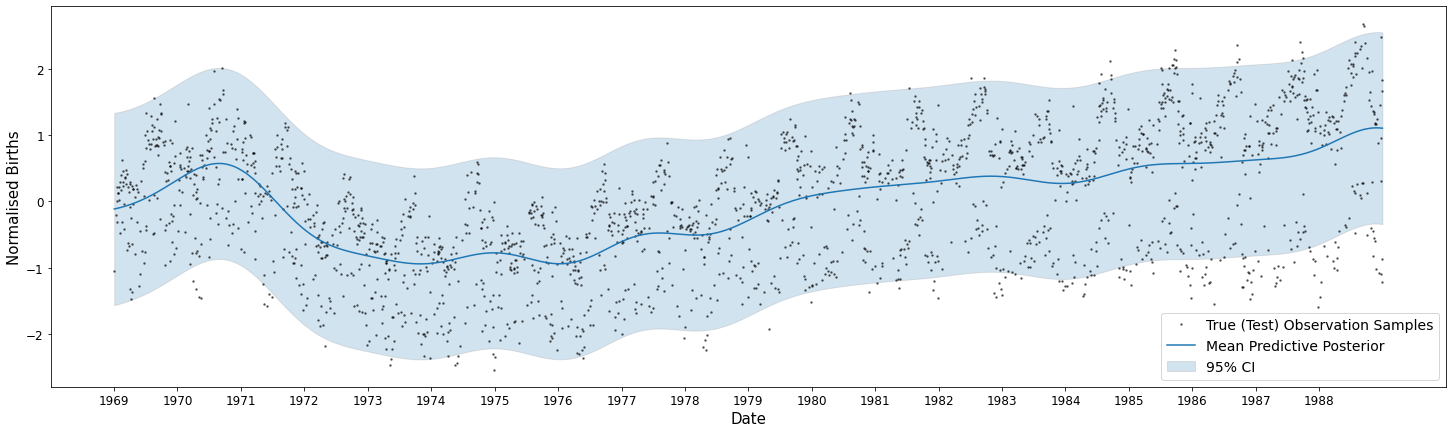

Train ELBO, MSE, MAE:  -6270.343016648319 0.651510792063243 0.6913413899471526 22.644888917467007
Test ELBO, MSE, MAE:  -6359.9343144367585 0.6702442841852623 0.7040179130611345 23.48572196840535


In [31]:
kernel1 = gpflow.kernels.RBF(lengthscales=365)

build_train_1layer_dgp(kernel1, num_inducing=1500, batch_size=500)

# 2-layer DGP with less data

100


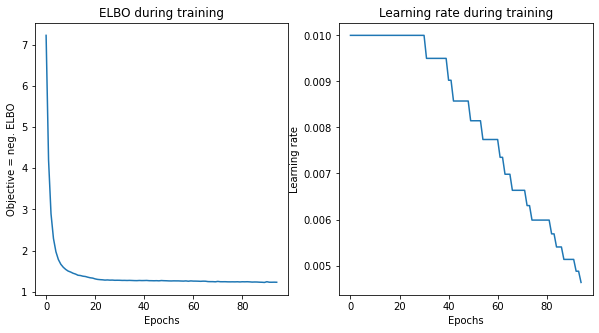

Training Set


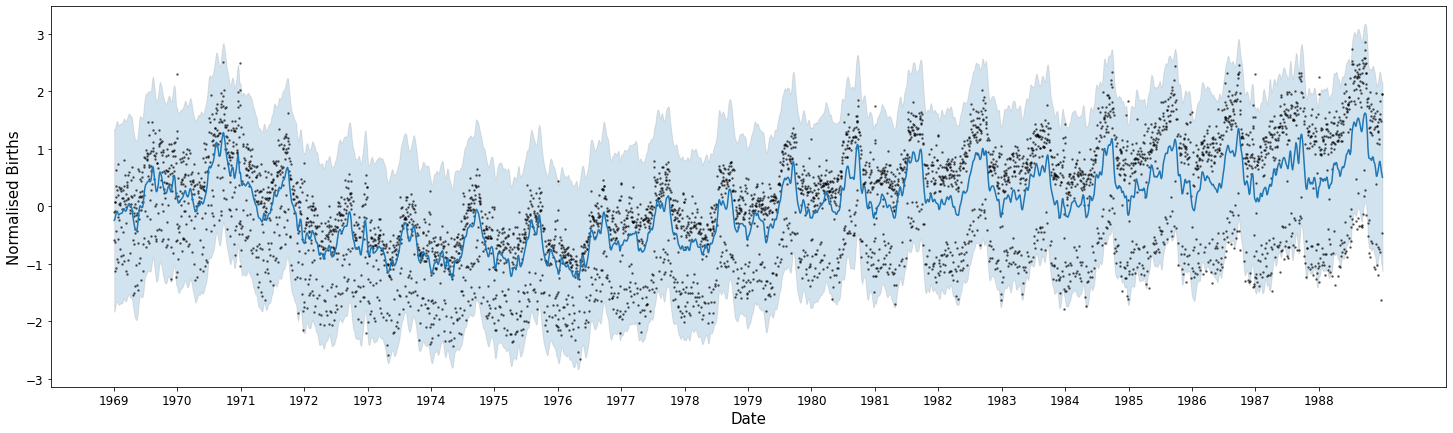

Testing Set


Train ELBO, MSE, MAE:  -6267.421298819491 0.5262552572024887 0.6894897452159576 19.011811640916846
Test ELBO, MSE, MAE:  -6749.73745255053 0.6324653929626732 0.7012111077917227 19.590981139112365


------------------------
300


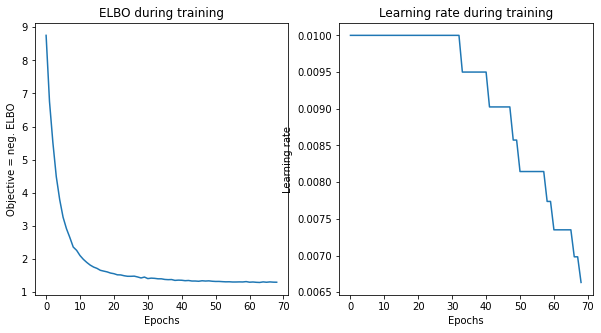

Training Set


Testing Set


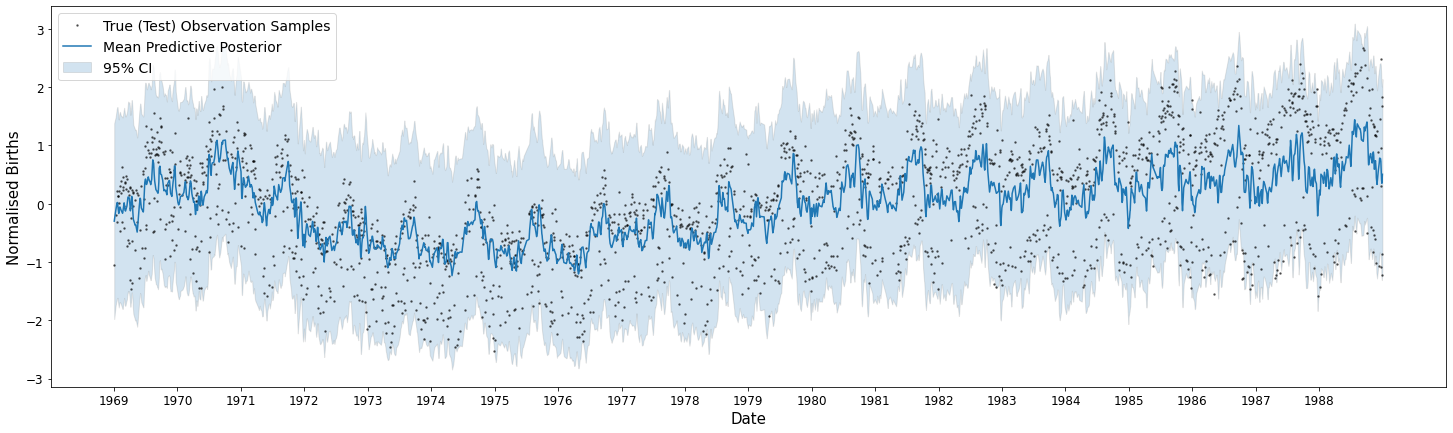

Train ELBO, MSE, MAE:  -6612.688968615865 0.5109826082963771 0.6737282695267609 16.64271294291741
Test ELBO, MSE, MAE:  -7492.879207216288 0.6918046121480919 0.680898172398919 16.477906554691245


------------------------
500


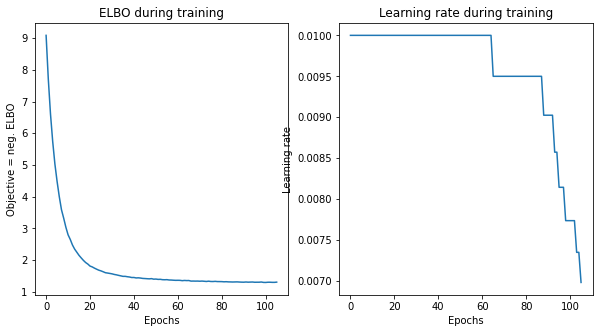

Training Set


Testing Set


Train ELBO, MSE, MAE:  -6628.858763443491 0.4996607243140362 0.6766478325477542 17.18754046290965
Test ELBO, MSE, MAE:  -7635.756525082075 0.7004744640551767 0.6828580413665397 16.879874227449516


------------------------


In [35]:
bs = [100, 300, 500]

for b in bs:
    print(b)
    build_train_2layer_dgp(gpflow.kernels.RBF(), gpflow.kernels.Matern32(), num_inducing=1500, batch_size=b)
    print('------------------------')